# Разработка A/B-тестирования и анализ результатов

* Автор: Кокорин Максим
* Дата: 08.09.2025

## Цели и задачи проекта

Выяснить, стоит ли применять новый алгоритм рекомендаций для всех пользователей приложения.

Задачи:
* познакомиться с данными и при необходимости предобработать;
* провести анализ количества регистраций и просмотров страниц;
* определить долю успешных сессий;
* сформулировать нулевую и альтернативную гипотезы;
* определиться с целевой метрикой;
* рассчитать необходимый размер выборки.
* рассчитать необходимую длительность проведения теста;
* проверить распределение и пересечение пользователей двух групп;
* получить результат теста и посчитать основную метрику;
* сравнить доли успешных сессий;
* провести Т-тест и Z-тест.


## Содержимое проекта
* Работа с историческими данными (EDA)
* Подготовка к тесту
* Мониторинг А/В-теста
* Проверка результатов A/B-теста

## Описание данных

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02.

У таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных

In [1]:
# Импортируем библиотеки для работы с данными
import pandas as pd
import numpy as np

# Импортируем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Импортируем библиотеку для Z-теста
from statsmodels.stats.proportion import proportions_ztest

# Импортируем библиотеку для T-теста
from scipy.stats import ttest_ind

# Устанавливаем библиотеку для определения размеров выборки
!pip install statsmodels

from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Импортируем математическую библиотеку
from math import ceil


[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Выгружаем данные в переменную sessions_history
sessions_history = pd.read_csv('...')

# Выведем первые 5 строк полученного датафрейма
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [3]:
# Расчитаем количество уникальных сессий для каждого пользователя
count_sessions = sessions_history.groupby('user_id')['session_id'].nunique().reset_index()

# Сохраним максимальное число сессий на одного пользователя
max_count_sessions = count_sessions.max()

# Сохраним идентификатор пользователя с максимальным количеством сессий
user_id_max_sessions = list(count_sessions[count_sessions['session_id'] == max_count_sessions['session_id']]['user_id'].head(1))[0]

# Выведем данные из таблицы для этого пользователя
sessions_history[sessions_history['user_id'] == user_id_max_sessions]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


Есть три столбца, в которых присутствует дата, однако в самом датафрейме их тип данных определен неверно.

In [4]:
# Изменим тип данных трёх столбцов на дату
for column in ['session_date', 'session_start_ts', 'install_date']:
    sessions_history[column] = pd.to_datetime(sessions_history[column])
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   user_id            435924 non-null  object        
 1   session_id         435924 non-null  object        
 2   session_date       435924 non-null  datetime64[ns]
 3   session_start_ts   435924 non-null  datetime64[ns]
 4   install_date       435924 non-null  datetime64[ns]
 5   session_number     435924 non-null  int64         
 6   registration_flag  435924 non-null  int64         
 7   page_counter       435924 non-null  int64         
 8   region             435924 non-null  object        
 9   device             435924 non-null  object        
dtypes: datetime64[ns](3), int64(3), object(4)
memory usage: 33.3+ MB


#### 1.3. Анализ числа регистраций

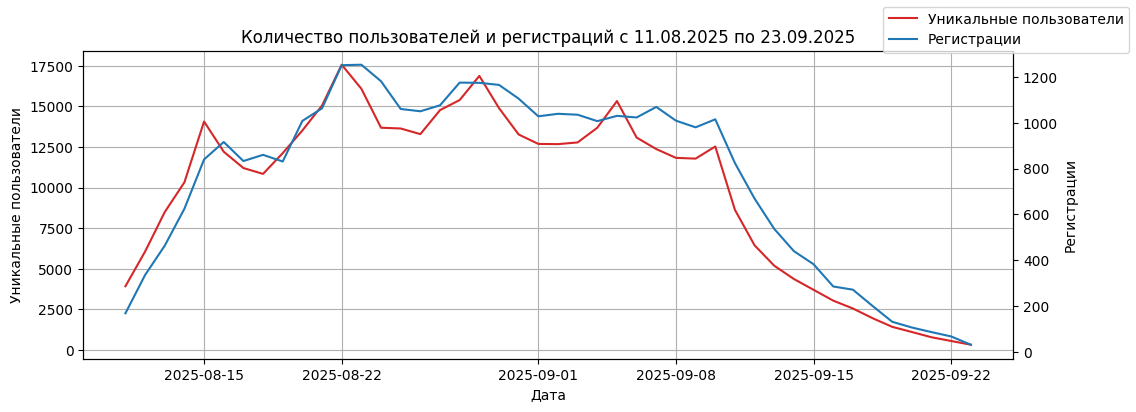

In [5]:
# Посчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения
count_uniq_user = sessions_history.groupby('session_date')['user_id'].nunique()
count_reg_user = sessions_history.groupby('session_date')['registration_flag'].sum()

# Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням
fig, ax1 = plt.subplots(figsize=(12, 4))

ax1.set_xlabel('Дата')
ax1.set_ylabel('Уникальные пользователи')
line1, = ax1.plot(count_uniq_user, color='tab:red', label='Уникальные пользователи')
plt.grid()

ax2 = ax1.twinx()
ax2.set_ylabel('Регистрации')
line2, = ax2.plot(count_reg_user, color='tab:blue', label='Регистрации')

fig.legend([line1, line2], ['Уникальные пользователи', 'Регистрации'])

plt.title('Количество пользователей и регистраций с 11.08.2025 по 23.09.2025')
plt.show()


Количество пользователей и регистраций росло до 22 августа, затем до 8 сентября число пользователей снизилось с 17500 до 12500, а регистраций — с 1200 до 1000. После этого наблюдается резкий спад обоих показателей до 23 сентября. Возможно, в этот период была какая-либо акция или другое событие, что повлияло на рост числа пользователей и регистраций и к 23 сентября показатели перешли в свои обычные значения.

Text(0.5, 0, 'Дата')

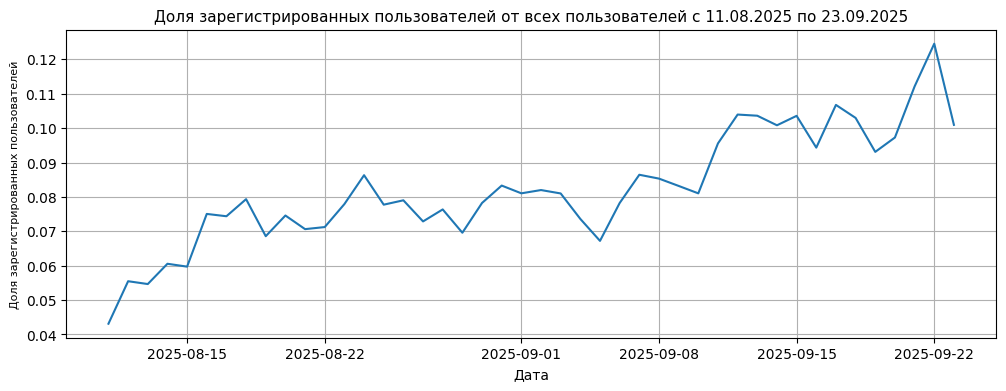

In [6]:
# Посчитаем доли зарегистрированных пользователей от всех пользователей по дням
count_reg_user_share = count_reg_user / count_uniq_user

# На основе полученных данных построим линейный график
plt.figure(figsize=(12, 4))
plt.plot(count_reg_user_share)
plt.grid()
plt.title('Доля зарегистрированных пользователей от всех пользователей с 11.08.2025 по 23.09.2025', fontsize=11)
plt.ylabel('Доля зарегистрированных пользователей', fontsize=8)
plt.xlabel('Дата')

Доля зарегистрированных пользователей от их общего числа стабильно растет, что говорит о большей заинтересованности в сервисе тех, кто посещает приложение.

#### 1.4. Анализ числа просмотренных страниц

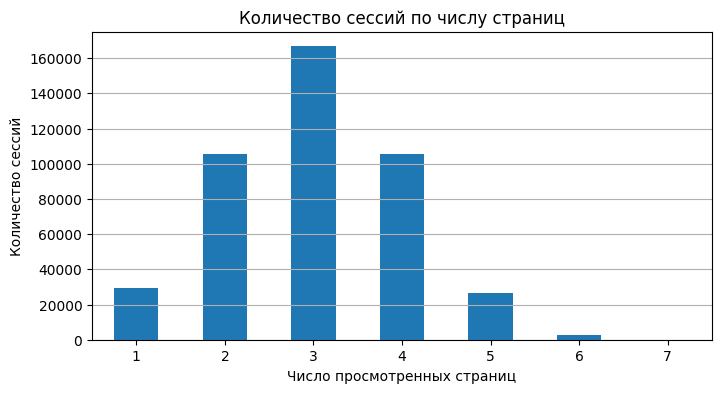

In [7]:
# Найдем количество сессий для каждого значения количества просмотренных страниц
count_sessions = sessions_history.groupby('page_counter')['session_id'].count()

# Построим столбчатую диаграмму
count_sessions.plot(kind='bar', figsize=(8,4), rot=0)
plt.title('Количество сессий по числу страниц')
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')
plt.grid(axis='y')

Больше всего сессий набрали 3 страницы — почти медианное значение. Компании нужно стремиться повышать количество сессий для пяти и более страниц, так как их доля от общего количества минимальна. Для этого можно разработать маркетинговые кампании.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц

In [8]:
# Создадим функцию, которая возвращает 1, если за одну сессию было просмотрено 4 и более страниц, и значение 0 в ином случае
def func_good_session(row):
    if row['page_counter'] >= 4:
        return 1
    else:
        return 0

# Добавим новый столбец, логика заполнения которого представлена в ранее созданной функции
sessions_history['good_session'] = sessions_history.apply(func_good_session, axis=1)

# Проверим, что все получилось, выводом первых пяти строк
sessions_history[['page_counter', 'good_session']].head()

,page_counter,good_session
0,3,0
1,4,1
2,4,1
3,4,1
4,3,0


Text(0.5, 0, 'Дата')

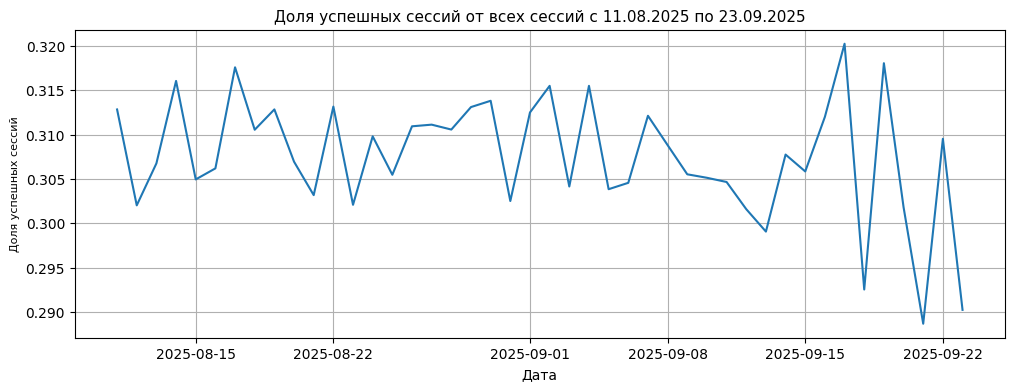

In [9]:
# Подготовим необходимые данны для графика: количество сессий, количество успешных сессий, долю успешных сессий от всех сессий
count_sessions = sessions_history.groupby('session_date')['good_session'].count()
count_good_sessions = sessions_history.groupby('session_date')['good_session'].sum()
good_sessions_share = count_good_sessions / count_sessions

# Построим график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения
plt.figure(figsize=(12, 4))
plt.plot(good_sessions_share)
plt.grid()
plt.title('Доля успешных сессий от всех сессий с 11.08.2025 по 23.09.2025', fontsize=11)
plt.ylabel('Доля успешных сессий', fontsize=8)
plt.xlabel('Дата')

Доля пользователей, просмотревших более 4 страниц, на протяжении всего периода нестабильна, но эти значения не на много отличаются между собой — от 0.29 до 0.32. За каждым подъемом следует спад, зачастую резкий. Можно попробовать найти взаимосвязи между датами и долями, провести маркетинговые кампании, направленные на повышение доли успешных сессий.

### 2. Подготовка к тесту

#### 2.1 Формулировка нулевой и альтернативной гипотез

Речь идет о такой метрике, как количество сессий. Если рекомендации, для логики показа которых был разработан новый алгоритм, заинтересовали клиента, то он будет чаще будет заходить в приложение.

- H₀: доля успешных сессий в тестовой группе B меньше или равна, чем в контрольной группе A.
- H₁: доля успешных сессий в тестовой группе B больше, чем в контрольной группе A.

#### 2.2. Расчёт размера выборки

In [10]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p1 = 0.3 # Базовый уровень доли
mde = 0.03 * p1  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p1, p1 + mde) 

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста

In [11]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = round(count_uniq_user.mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size / avg_daily_users * 2)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

In [12]:
# Сохраним данные из файла sessions_project_test_part.csv в переменную sessions_test_part
sessions_test_part = pd.read_csv('...')

# Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения
count_user_a = sessions_test_part.groupby('test_group')['user_id'].nunique()['A']
count_user_b = sessions_test_part.groupby('test_group')['user_id'].nunique()['B']

# Рассчитаем процентную разницу в количестве пользователей в группах A и B
100 * abs(count_user_a - count_user_b) / count_user_a

0.7447528774542993

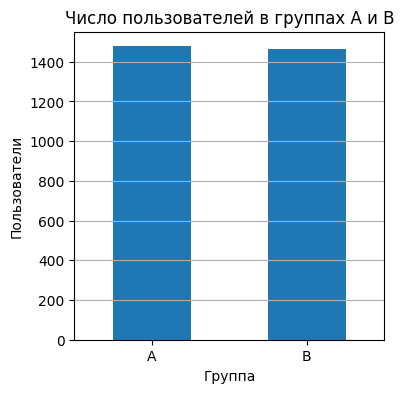

In [13]:
# Построим столбчатую диаграмму для отображения возможного различие двух групп
count_user_a_b = pd.Series([count_user_a, count_user_b], ['A', 'B'])
plt.figure(figsize=(4, 4))
count_user_a_b.plot(kind='bar', rot=0, title='Число пользователей в группах A и B', xlabel='Группа', ylabel='Пользователи')
plt.grid(axis='y')

Количество пользователей в обеих группах почти одинаковое, что говорит о равенстве между группами в плане объема.

#### 3.2. Проверка пересечений пользователей

In [14]:
# Проверим, есть ли пользователи, которые попали в обе группы одновременно
set_A = set(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'])
set_B = set(sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'])
set_A & set_B

set()

Получили пустое множество, значит таких пользователей нет.

#### 3.3. Равномерность разделения пользователей по устройствам

Text(0, 0.5, 'Доля девайсов от всех устройств')

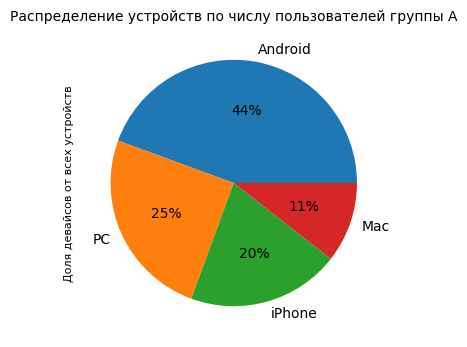

In [15]:
# Посчитаем нужные данные для построения диаграммы: количество пользователей для каждого типа девайса, общее количество пользователей, долю первой переменной от второй
count_device_A = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('device')['user_id'].nunique()
count_device_sum_A = count_device_A.sum()
device_share_A = (count_device_A / count_device_sum_A).sort_values(ascending=False)

# Построим круговую диаграмму долей каждого типа устройства для пользователей из группы A
plt.figure(figsize=(6, 4))
device_share_A.plot(kind='pie', rot=0, autopct='%1.f%%')
plt.title('Распределение устройств по числу пользователей группы А', fontsize=10)
plt.ylabel('Доля девайсов от всех устройств', fontsize=8)

Text(0, 0.5, 'Доля девайсов от всех устройств')

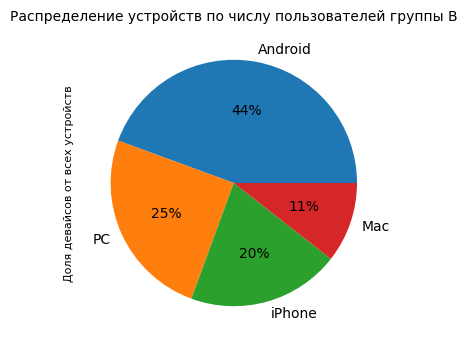

In [16]:
# Проведем аналогичные вычисления для группы В
count_device_B = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('device')['user_id'].nunique()
count_device_sum_B = count_device_B.sum()
device_share_B = (count_device_B / count_device_sum_B).sort_values(ascending=False)

# Построим круговую диаграмму долей каждого типа устройства для пользователей из группы В
plt.figure(figsize=(6, 4))
device_share_A.plot(kind='pie', rot=0, autopct='%1.f%%')
plt.title('Распределение устройств по числу пользователей группы В', fontsize=10)
plt.ylabel('Доля девайсов от всех устройств', fontsize=8)

Так как процентное соотношение в обеих группах одинаково, то данные по устройствам разделены равномерно.

#### 3.4. Равномерность распределения пользователей по регионам

Text(0, 0.5, 'Доля региона от всех регионов')

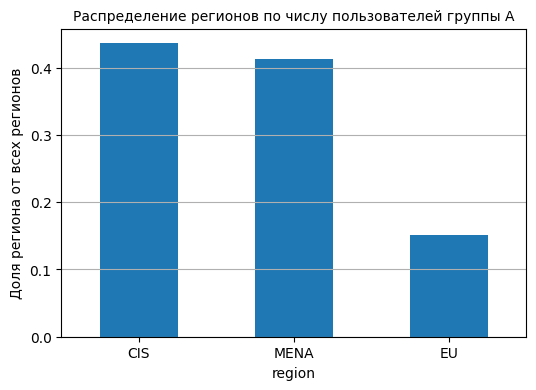

In [17]:
# Посчитаем нужные данные для построения диаграммы: количество пользователей в каждом регионе, количество пользователей во всех регионах, долю первой переменной от второй
count_region_A = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('region')['user_id'].nunique()
count_region_sum_A = count_region_A.sum()
region_share_A = (count_region_A / count_region_sum_A).sort_values(ascending=False)

# Построим столбчатую диаграмму распределения регионов в группе А
plt.figure(figsize=(6, 4))
region_share_A.plot(kind='bar', rot=0)
plt.title('Распределение регионов по числу пользователей группы А', fontsize=10)
plt.grid(axis='y')
plt.ylabel('Доля региона от всех регионов')

Text(0, 0.5, 'Доля региона от всех регионов')

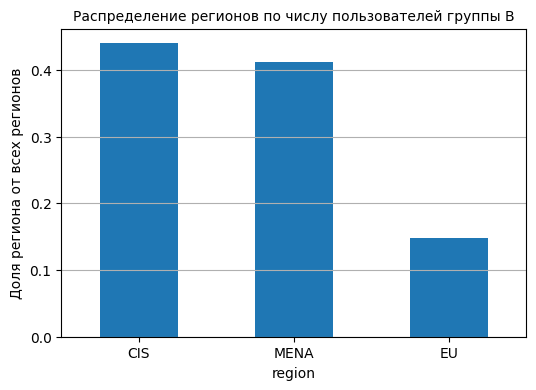

In [18]:
# Проведем аналогичные вычисления для группы В
count_region_B = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('region')['user_id'].nunique()
count_region_sum_B = count_region_B.sum()
region_share_B = (count_region_B / count_region_sum_B).sort_values(ascending=False)

# Построим столбчатую диаграмму распределения регионов в группе В
plt.figure(figsize=(6, 4))
region_share_B.plot(kind='bar', rot=0)
plt.title('Распределение регионов по числу пользователей группы B', fontsize=10)
plt.grid(axis='y')
plt.ylabel('Доля региона от всех регионов')

Распределение по регионам равно в двух группах.

#### 3.5. Вывод после проверки A/B-теста

Различие в количестве пользователей в двух группах незначительное. Выборки являются независимыми, поскольку мы не нашли пользователей, которые есть в обеих группах. Равномерное распределение пользователей как по устройствам, так и по регионам присутствует (в абсолютных значениях небольшая разница, в относительных отсутствует (в процентах)).

Это говорит о том, что A/B-тест проходит успешно, отклонений обнаружено не было.

### 4. Проверка результатов A/B-теста

#### 4.1. Получение результатов теста и подсчёт основной метрики

In [19]:
# Сохраним данные файла sessions_project_test.csv в датафрейм sessions_test
sessions_test = pd.read_csv('...')

# Создадим дополнительный столбец good_session по ранее созданной логике func_good_session (1.5)
sessions_test['good_session'] = sessions_test.apply(func_good_session, axis=1)

# Проверим результат
sessions_test[['page_counter', 'good_session']]

,page_counter,good_session
0,3,0
1,2,0
2,2,0
3,1,0
4,2,0
...,...,...
100000,3,0
100001,5,1
100002,3,0
100003,4,1


#### 4.2. Проверка корректности результатов теста

In [20]:
# Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку
count_sessions_A = sessions_test[sessions_test['test_group'] == 'A'].groupby('session_date')['session_id'].nunique().reset_index()
count_sessions_A

,session_date,session_id
0,2025-10-14,1502
1,2025-10-15,2235
2,2025-10-16,3280
3,2025-10-17,4089
4,2025-10-18,5013
5,2025-10-19,6535
6,2025-10-20,5837
7,2025-10-21,3927
8,2025-10-22,3083
9,2025-10-23,2470


In [21]:
count_sessions_B = sessions_test[sessions_test['test_group'] == 'B'].groupby('session_date')['session_id'].nunique().reset_index()
count_sessions_B

,session_date,session_id
0,2025-10-14,1628
1,2025-10-15,2283
2,2025-10-16,3241
3,2025-10-17,4054
4,2025-10-18,5059
5,2025-10-19,6779
6,2025-10-20,6089
7,2025-10-21,3981
8,2025-10-22,3111
9,2025-10-23,2548


Сформулируем гипотезы и проверим их с использованием статистического теста:
- H₀: количество уникальных дневных сессий не различается между тестовой и контрольной группами.
- H₁: количество уникальных дневных сессий различается между тестовой и контрольной группами.

In [22]:
# Проверим, что количество уникальных дневных сессий в двух выборках не различается или 
# различия не статистически значимыми с помощью Т-теста

metric_a = count_sessions_A['session_id']
metric_b = count_sessions_B['session_id']

alpha = 0.05
stat_ttest, p_value_ttest = ttest_ind(
    metric_a, 
    metric_b, 
    alternative='two-sided'
)

if p_value_ttest>alpha:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
    print('Интерпретация: обновление рекомендательной системы не изменило поведение пользователей')
else:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B больше')
    print('Интерпретация: обновление рекомендательной системы изменило поведение пользователей')

p-value теста Стьюдента =0.94
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны
Интерпретация: обновление рекомендательной системы не изменило поведение пользователей


#### 4.3. Сравнение доли успешных сессий

In [23]:
# Рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе
good_session_sum = sessions_test.groupby('test_group')['good_session'].sum()
session_sum = sessions_test.groupby('test_group')['good_session'].count()
good_session_share = good_session_sum / session_sum
good_session_share

test_group
A    0.307723
B    0.318290
Name: good_session, dtype: float64

In [24]:
good_session_share['B'] - good_session_share['A']

0.010566571724179463

#### 4.4. Насколько статистически значимо изменение ключевой метрики

Сформулируем гипотезы:
- H₀: изменение в метрике доли успешных сессий не является статистически значимым.
- H₁: изменение в метрике доли успешных сессий является статистически значимым.

In [25]:
# Используя Z-тест, рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым

n_a = sessions_test[sessions_test['test_group'] == 'A'].shape[0]
n_b = sessions_test[sessions_test['test_group'] == 'B'].shape[0]

m_a = good_session_sum['A']
m_b = good_session_sum['B']

p_a, p_b = m_a/n_a, m_b/n_b

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10): # проверим предпосылку о достаточном количестве данных
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

alpha = 0.05


stat_ztest, p_value_ztest = proportions_ztest( # проведите Z-тест пропорций
	[m_b, m_a],
    [n_b, n_a],
    alternative='larger'
)

print(f'pvalue={p_value_ztest}')

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение!')
else:
    print('Нулевая гипотеза не находит подтверждения!')

text_interpretation = 'не изменилось'

print(f'Количество просмотров с новой рекомендательной системой {text_interpretation}')

Предпосылка о достаточном количестве данных выполняется!
pvalue=0.0001574739988036123
Нулевая гипотеза не находит подтверждения!
Количество просмотров с новой рекомендательной системой не изменилось


#### 4.5. Вывод по результатам A/B-эксперимента

В группах A и B оказались практически равные значения по количеству сессий по дням. Об этом говорит разница долей между группами. Дальше это было подтверждено T-тестом, который подразумевает отсутствие разницы между средними выборок после внедрения нового алгоритма рекомендаций для пользователей. Для теста понадобилось 9 дней, в каждой группе оказалось примерно 1500 человек. P-value в T-тесте оказался больше уровня значимости `alpha`, а в Z-тесте — меньше. Z-тест показал, что статистически значимая разница есть, а значит нововведение стоит вводить.